In [4]:
%matplotlib inline
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.special
import openpyxl
from openpyxl import Workbook, load_workbook
from openpyxl.chart import ScatterChart, LineChart, Reference, Series
from openpyxl.chart.shapes import GraphicalProperties
from openpyxl.chart.layout import Layout, ManualLayout
from openpyxl.chart.text import RichText
from openpyxl.drawing.text import Paragraph, ParagraphProperties, CharacterProperties, Font, RichTextProperties
from openpyxl.drawing.line import LineProperties
from copy import deepcopy

In [5]:
#####関数の定義##############################################
def Gaussian(x, *params):
    num_Gaussian = int(len(params)/3)
    y_list = []
    for i in range(num_Gaussian):
        y = np.zeros_like(x)
        param_range = list(range(3*i,3*(i+1),1))
        amp = params[int(param_range[0])]
        ctr = params[int(param_range[1])]
        wid = params[int(param_range[2])] #全半値幅
        y = y + amp*np.exp(-((x-ctr)/wid)**2/2)
        y_list.append(y)
    y_sum = np.zeros_like(x)
    for i in y_list:
        y_sum = y_sum + i
    y_sum = y_sum + params[-1]
    return y_sum

def Lorentzian(x, *params):
    num_Lorentzian = int(len(params)/3)
    y_list = []
    for i in range(num_Lorentzian):
        y = np.zeros_like(x)
        param_range = list(range(3*i,3*(i+1),1))
        amp = params[int(param_range[0])] 
        ctr = params[int(param_range[1])] 
        wid = params[int(param_range[2])] #HWFM
        y = y + amp*(wid**2/(4*(x-ctr)**2+wid**2)) 
        y_list.append(y)
    y_sum = np.zeros_like(x)
    for i in y_list:
        y_sum = y_sum + i
    y_sum = y_sum + params[-1]
    return y_sum

def Voigt(x, *params):
    num_Voigt = int(len(params)/4)
    y_list = []
    for i in range(num_Voigt):
        y = np.zeros_like(x)
        param_range = list(range(4*i,4*(i+1),1))
        norm = params[int(param_range[0])] #normalization
        ctr = params[int(param_range[1])] #center of Lorentzian line
        lw = params[int(param_range[2])] #HWFM of Lorentzian 
        gw = params[int(param_range[3])] #sigma of the Gaussian
        z = (x - ctr + 1j*lw)/(gw * np.sqrt(2.0))
        w = scipy.special.wofz(z)
        y = y + norm*(w.real)/(gw * np.sqrt(2.0*np.pi))
        y_list.append(y)
    y_sum = np.zeros_like(x)
    for i in y_list:
        y_sum = y_sum + i
    y_sum = y_sum + params[-1]
    return y_sum

def plot_G(x, *params):
    num_Gaussian = int(len(params)/3)
    y_list = []
    for i in range(num_Gaussian):
        y = np.zeros_like(x)
        param_range = list(range(3*i,3*(i+1),1))
        amp = params[int(param_range[0])]
        ctr = params[int(param_range[1])]
        wid = params[int(param_range[2])] #HWHM
        y = y + amp*np.exp(-((x-ctr)/wid)**2/2) + params[-1]
        y_list.append(y)
    return y_list

def plot_L(x, *params):
    num_Lorentzian = int(len(params)/3)
    y_list = []
    for i in range(num_Lorentzian):
        y = np.zeros_like(x)
        param_range = list(range(3*i,3*(i+1),1))
        amp = params[int(param_range[0])] 
        ctr = params[int(param_range[1])] 
        wid = params[int(param_range[2])] #FWHM
        y = y + amp*(wid**2/(4*(x-ctr)**2+wid**2))  + params[-1]
        y_list.append(y)
    return y_list

def plot_V(x, *params):
    num_Voigt = int(len(params)/4)
    y_list = []
    for i in range(num_Voigt):
        y = np.zeros_like(x)
        param_range = list(range(4*i,4*(i+1),1))
        norm = params[int(param_range[0])] #normalization
        ctr = params[int(param_range[1])] #center of Lorentzian line
        lw = params[int(param_range[2])] #HWFM of Lorentzian 
        gw = params[int(param_range[3])] #sigma of the Gaussian
        z = (x - ctr + 1j*lw)/(gw * np.sqrt(2.0))
        w = scipy.special.wofz(z)
        y = y + norm*(w.real)/(gw * np.sqrt(2.0*np.pi))
        y_list.append(y)
    return y_list

def num_peak(*params):
    num_peak=int(len(params)/3)
    return num_peak



# 2θ/ω-scan

Text(0.5, 0, '2$\\it{θ}$ (deg.)')

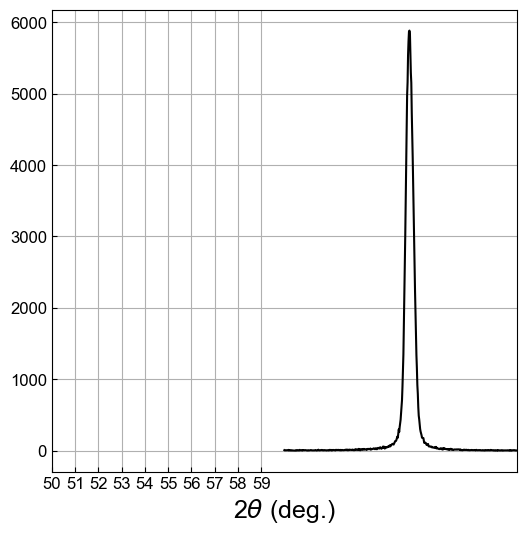

In [8]:
#####データの代入############################################
Path='/Users/ueno2/iCloudDrive/研究/FeCoNi3元合金/データ/xrd'
dataname='240228'
filename='240228fe4-op'
date='240301'
save_path='/Users/ueno2/iCloudDrive/研究/FeCoNi3元合金/データ/解析/新試料/xrd'

x0_list=[]
y0_list=[]
xr_list=[]
yr_list=[]

tths=60
tthe=70

f= open(f'{Path}/{dataname}/{filename}.txt','rt')
for i in range(256):
    next(f)
for line in f :
    data = line[:-1].split(',')
    if tths<= float(data[0]) <=tthe:
        x0_list.append(float(data[0]))
        y0_list.append(float(data[1]))
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))
    else:
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))
    
##保存先のファイルネーム
output_filename=f'summary_{dataname}.xlsx'


plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure(figsize=(6.0, 6.0))

#plt.yscale('log')
plt.plot(x0_list,y0_list,c='Black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.xlim(60,70)
plt.xticks(np.arange(50,60,1))
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)


In [11]:
##初期パラメータ(大体の値を代入)
guess = [] #[amp,ctr,wid]
guess.append([4000,65,0.5])
background = 5
guess_total = []
for i in guess:
    guess_total.extend(i)
nop=int(len(guess_total)/3)
guess_total.append(background)

print(nop)

1


##Gaussian####################
◯PEAK1
面積:2397.7455612525487
中心:65.38673659765503
全半値幅:0.33105719765794694
格子定数:2.851097281625775
##Lorenztian####################
●PEAK1
面積:3177.3778490289837
中心:65.38367598350945
全半値幅:0.31964470023179875
##Voigt##########
●PEAK1
面積:2591.924319913527
中心:65.38621635609151
全半値幅:0.32983273704569493
格子定数:2.851117449096068


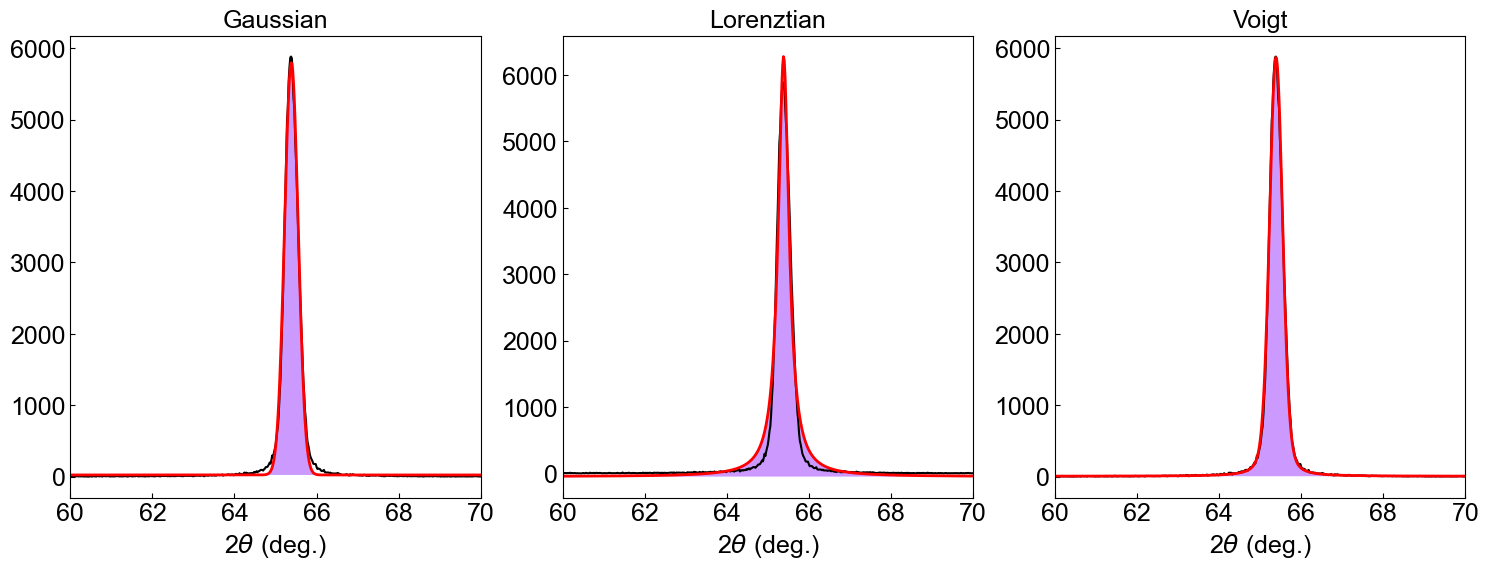

In [12]:
%matplotlib inline
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.special

plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure(figsize=(18.0, 6.0))

data=[]
data.clear()
data.append(x0_list)
data.append(x0_list)

###Gaussian#########################
poptG, pcovG = curve_fit(Gaussian, x0_list, y0_list, p0=guess_total, maxfev=5000)
fitG = Gaussian(x0_list, *poptG)
data.append(fitG)
print('##Gaussian####################')
for i in range(nop):
    print(f'◯PEAK{i+1}')
    print(f'面積:{np.sqrt(2*np.pi)*poptG[3*i]*poptG[3*i+2]}')
    print(f'中心:{poptG[3*i+1]}')
    print(f'全半値幅:{abs(2*poptG[3*i+2])}')
    print(f'格子定数:{2*1.54/(2*np.sin(np.radians(poptG[3*i+1]/2)))}')

plt.subplot(1,3,1)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitG , ls='-', c='red', lw=2)

y_list = plot_G(x0_list, *poptG)
baseline = np.zeros_like(x0_list)+poptG[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)
    
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(tths,tthe)
plt.title('Gaussian', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)
#plt.ylabel('intensity', fontsize=18)



###Lorenztian######################
poptL, pcovL = curve_fit(Lorentzian, x0_list, y0_list, p0=guess_total)
fitL = Lorentzian(x0_list, *poptL)
print('##Lorenztian####################')
for i in range(nop):
    print(f'●PEAK{i+1}')
    print(f'面積:{np.pi/2*poptL[3*i]*abs(poptL[3*i+2])}')
    print(f'中心:{poptL[3*i+1]}')
    print(f'全半値幅:{abs(poptL[3*i+2])}')

plt.subplot(1,3,2)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitL , ls='-', c='red', lw=2)

y_list = plot_L(x0_list, *poptL)
baseline = np.zeros_like(x0_list)+poptL[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(tths,tthe)
plt.title('Lorenztian', fontsize=18)
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)

###Voigt######################
guessV = [] #[norm,ctr,lw,gw]
for i in range(nop):
    guessV.append([poptL[3*i],poptG[3*i+1],abs(poptL[3*i+2]),abs(poptG[3*i+2])])
background = 5
guess_total_V = []
for i in guessV:
    guess_total_V.extend(i)
guess_total_V.append(background)

poptV, pcovV = curve_fit(Voigt, x0_list, y0_list, p0=guess_total_V)
fitV = Voigt(x0_list, *poptV)
print('##Voigt##########')
for i in range(nop):
    print(f'●PEAK{i+1}')
    print(f'面積:{poptV[4*i]}')
    print(f'中心:{poptV[4*i+1]}')
    print(f'全半値幅:{2*(0.5346*poptV[4*i+2]+np.sqrt(0.2166*poptV[4*i+2]**2+poptV[4*i+3]**2))}')
    print(f'格子定数:{2*1.54/(2*np.sin(np.radians(poptV[4*i+1]/2)))}')

plt.subplot(1,3,3)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitV , ls='-', c='red', lw=2)

y_list = plot_V(x0_list, *poptV)
baseline = np.zeros_like(x0_list)+poptV[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(tths,tthe)
plt.title('Voigt', fontsize=18)
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)

###エクセルに保存###

plt.show()


In [ ]:
%matplotlib inline
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.special

fig = plt.figure(figsize=(6.0, 6.0))
ax = fig.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')



#plt.vlines(64.568,0, 1000, colors='BLACK', linestyle='dashed', linewidth=1)
#plt.text(63,500,"Cr (002)",rotation='vertical',fontsize=15)
#plt.text(46,500,"MgO (002)",rotation='vertical',fontsize=15)

##生データ
plt.plot(xr_list, yr_list,color='BLACK',lw=1.5)
plt.plot(x0_list, fitV , ls='-', c='red', lw=1)
y_list = plot_V(x0_list, *poptV)
baseline = np.zeros_like(x0_list)+poptV[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)


plt.yscale('log')
plt.ylim(0, 9000)
#plt.xlim(63, 67)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.minorticks_on()
#plt.grid(True)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)
plt.ylabel('intensity', fontsize=18)  
plt.tick_params(labelleft=False)

fig.savefig(f'{Path}/{dataname}/peak_CrFe.pdf',format="pdf", bbox_inches="tight", pad_inches=0.1)
    

# 2θ/ω-scan parallel to Cr110

In [ ]:
#####データの代入############################################
filename='2th-th_CrFe110'

x0_list=[]
y0_list=[]
xr_list=[]
yr_list=[]

f= open(f'{Path}/{dataname}/{filename}.txt','rt')
for i in range(256):
    next(f)
for line in f :
    data = line[:-1].split(',')
    if 40<= float(data[0]) <=50:
        x0_list.append(float(data[0]))
        y0_list.append(float(data[1]))
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))
    else:
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))

plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure(figsize=(6.0, 6.0))

plt.plot(x0_list,y0_list,c='Black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.xlim(44,46)
plt.xticks(np.arange(44,46,0.2))
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)

In [ ]:
##初期パラメータ(大体の値を代入)
#Crの001ピーク強度
guess = [] #[amp,ctr,wid]
guess.append([3000,44.6,0.5])
guess.append([16000,44.8,0.5])
background = 5
guess_total = []
for i in guess:
    guess_total.extend(i)
nop=int(len(guess_total)/3)
guess_total.append(background)

print(nop)

In [ ]:
%matplotlib inline
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.special

plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure(figsize=(18.0, 6.0))

data=[]
data.clear()
data.append(x0_list)
data.append(x0_list)

###Gaussian#########################
poptG, pcovG = curve_fit(Gaussian, x0_list, y0_list, p0=guess_total,maxfev=5000)
fitG = Gaussian(x0_list, *poptG)
data.append(fitG)
print('##Gaussian####################')
for i in range(nop):
    print(f'◯PEAK{i+1}')
    print(f'面積:{np.sqrt(2*np.pi)*poptG[3*i]*poptG[3*i+2]}')
    print(f'中心:{poptG[3*i+1]}')
    print(f'全半値幅:{abs(2*poptG[3*i+2])}')

plt.subplot(1,3,1)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitG , ls='-', c='red', lw=2)

y_list = plot_G(x0_list, *poptG)
baseline = np.zeros_like(x0_list)+poptG[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)
    
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(43,47)
plt.title('Gaussian', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)
#plt.ylabel('intensity', fontsize=18)



###Lorenztian######################
poptL, pcovL = curve_fit(Lorentzian, x0_list, y0_list, p0=guess_total)
fitL = Lorentzian(x0_list, *poptL)
print('##Lorenztian####################')
for i in range(nop):
    print(f'●PEAK{i+1}')
    print(f'面積:{np.pi/2*poptL[3*i]*abs(poptL[3*i+2])}')
    print(f'中心:{poptL[3*i+1]}')
    print(f'全半値幅:{abs(poptL[3*i+2])}')

plt.subplot(1,3,2)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitL , ls='-', c='red', lw=2)

y_list = plot_L(x0_list, *poptL)
baseline = np.zeros_like(x0_list)+poptL[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(43,47)
plt.title('Lorenztian', fontsize=18)
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)

###Voigt######################
guessV = [] #[norm,ctr,lw,gw]
for i in range(nop):
    guessV.append([poptG[3*i],poptL[3*i+1],abs(poptL[3*i+2]),abs(poptG[3*i+2])])
background = 5
guess_total_V = []
for i in guessV:
    guess_total_V.extend(i)
guess_total_V.append(background)

poptV, pcovV = curve_fit(Voigt, x0_list, y0_list, p0=guess_total_V, maxfev=10000)
fitV = Voigt(x0_list, *poptV)
print('##Voigt##########')
for i in range(nop):
    print(f'●PEAK{i+1}')
    print(f'面積:{poptV[4*i]}')
    print(f'中心:{poptV[4*i+1]}')
    print(f'全半値幅:{2*(0.5346*poptV[4*i+2]+np.sqrt(0.2166*poptV[4*i+2]**2+poptV[4*i+3]**2))}')

plt.subplot(1,3,3)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitV , ls='-', c='red', lw=2)

y_list = plot_V(x0_list, *poptV)
baseline = np.zeros_like(x0_list)+poptV[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(43,47)
plt.title('Voigt', fontsize=18)
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)

###エクセルに保存###

plt.show()


# Rocking curve parallel to Cr001

In [ ]:
#####データの代入############################################
filename='RC_Cr002'

x0_list=[]
y0_list=[]
xr_list=[]
yr_list=[]

f= open(f'{Path}/{dataname}/{filename}.txt','rt')
for i in range(256):
    next(f)
for line in f :
    data = line[:-1].split(',')
    if 30<= float(data[0]) <=35:
        x0_list.append(float(data[0]))
        y0_list.append(float(data[1]))
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))
    else:
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))
        
x_RC_Cr=x0_list
y_RC_Cr=y0_list


In [5]:
##初期パラメータ(大体の値を代入)
#Crの001ピーク強度
amp=250
guess = [] #[amp,ctr,wid]
guess.append([amp,32.284,0.5])
background = 5
guess_total = []
for i in guess:
    guess_total.extend(i)
nop=int(len(guess_total)/3)
guess_total.append(background)

print(nop)

1


In [6]:
%matplotlib inline
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.special

plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure(figsize=(18.0, 6.0))

data=[]
data.clear()
data.append(x0_list)
data.append(x0_list)

###Gaussian#########################
poptG, pcovG = curve_fit(Gaussian, x0_list, y0_list, p0=guess_total)
fitG = Gaussian(x0_list, *poptG)
data.append(fitG)
print('##Gaussian####################')
for i in range(nop):
    print(f'◯PEAK{i+1}')
    print(f'面積:{np.sqrt(2*np.pi)*poptG[3*i]*poptG[3*i+2]}')
    print(f'中心:{poptG[3*i+1]}')
    print(f'全半値幅:{abs(2*poptG[3*i+2])}')

plt.subplot(1,3,1)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitG , ls='-', c='red', lw=2)

y_list = plot_G(x0_list, *poptG)
baseline = np.zeros_like(x0_list)+poptG[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)
    
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(31,34)
plt.title('Gaussian', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)
#plt.ylabel('intensity', fontsize=18)



###Lorenztian######################
poptL, pcovL = curve_fit(Lorentzian, x0_list, y0_list, p0=guess_total)
fitL = Lorentzian(x0_list, *poptL)
print('##Lorenztian####################')
for i in range(nop):
    print(f'●PEAK{i+1}')
    print(f'面積:{np.pi/2*poptL[3*i]*abs(poptL[3*i+2])}')
    print(f'中心:{poptL[3*i+1]}')
    print(f'全半値幅:{abs(poptL[3*i+2])}')

plt.subplot(1,3,2)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitL , ls='-', c='red', lw=2)

y_list = plot_L(x0_list, *poptL)
baseline = np.zeros_like(x0_list)+poptL[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(31,34)
plt.title('Lorenztian', fontsize=18)
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)

###Voigt######################
guessV = [] #[norm,ctr,lw,gw]
for i in range(nop):
    guessV.append([poptG[3*i],poptL[3*i+1],abs(poptL[3*i+2]),abs(poptG[3*i+2])])
background = 5
guess_total_V = []
for i in guessV:
    guess_total_V.extend(i)
guess_total_V.append(background)

poptV, pcovV = curve_fit(Voigt, x0_list, y0_list, p0=guess_total_V)
fitV = Voigt(x0_list, *poptV)
print('##Voigt##########')
for i in range(nop):
    print(f'●PEAK{i+1}')
    print(f'面積:{poptV[4*i]}')
    print(f'中心:{poptV[4*i+1]}')
    print(f'全半値幅:{2*(0.5346*poptV[4*i+2]+np.sqrt(0.2166*poptV[4*i+2]**2+poptV[4*i+3]**2))}')

plt.subplot(1,3,3)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitV , ls='-', c='red', lw=2)

y_list = plot_V(x0_list, *poptV)
baseline = np.zeros_like(x0_list)+poptV[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(31,34)
plt.title('Voigt', fontsize=18)
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)

###エクセルに保存###

plt.show()


NameError: name 'x0_list' is not defined

<Figure size 1800x600 with 0 Axes>

# Rocking curve parallel to Fe002

In [ ]:
#####データの代入############################################
filename='RC_Fe002'

x0_list=[]
y0_list=[]
xr_list=[]
yr_list=[]

f= open(f'{Path}/{dataname}/{filename}.txt','rt')
for i in range(256):
    next(f)
for line in f :
    data = line[:-1].split(',')
    if 30<= float(data[0]) <=35:
        x0_list.append(float(data[0]))
        y0_list.append(float(data[1]))
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))
    else:
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))

x_RC_Fe=x0_list
y_RC_Fe=y0_list

In [ ]:
##初期パラメータ(大体の値を代入)
#Crの001ピーク強度
amp=250
guess = [] #[amp,ctr,wid]
guess.append([amp,32.284,0.5])
background = 5
guess_total = []
for i in guess:
    guess_total.extend(i)
guess_total.append(background)

In [ ]:
%matplotlib inline
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.special

plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure(figsize=(18.0, 6.0))

data=[]
data.clear()
data.append(x0_list)
data.append(x0_list)

###Gaussian#########################
poptG, pcovG = curve_fit(Gaussian, x0_list, y0_list, p0=guess_total)
fitG = Gaussian(x0_list, *poptG)
data.append(fitG)
print('##Gaussian####################')
for i in range(nop):
    print(f'◯PEAK{i+1}')
    print(f'面積:{np.sqrt(2*np.pi)*poptG[3*i]*poptG[3*i+2]}')
    print(f'中心:{poptG[3*i+1]}')
    print(f'全半値幅:{abs(2*poptG[3*i+2])}')

plt.subplot(1,3,1)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitG , ls='-', c='red', lw=2)

y_list = plot_G(x0_list, *poptG)
baseline = np.zeros_like(x0_list)+poptG[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)
    
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(31.5,34.5)
plt.title('Gaussian', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)
#plt.ylabel('intensity', fontsize=18)



###Lorenztian######################
poptL, pcovL = curve_fit(Lorentzian, x0_list, y0_list, p0=guess_total)
fitL = Lorentzian(x0_list, *poptL)
print('##Lorenztian####################')
for i in range(nop):
    print(f'●PEAK{i+1}')
    print(f'面積:{np.pi/2*poptL[3*i]*abs(poptL[3*i+2])}')
    print(f'中心:{poptL[3*i+1]}')
    print(f'全半値幅:{abs(poptL[3*i+2])}')

plt.subplot(1,3,2)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitL , ls='-', c='red', lw=2)

y_list = plot_L(x0_list, *poptL)
baseline = np.zeros_like(x0_list)+poptL[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(31.5,34.5)
plt.title('Lorenztian', fontsize=18)
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)

###Voigt######################
guessV = [] #[norm,ctr,lw,gw]
for i in range(nop):
    guessV.append([poptG[3*i],poptL[3*i+1],abs(poptL[3*i+2]),abs(poptG[3*i+2])])
background = 5
guess_total_V = []
for i in guessV:
    guess_total_V.extend(i)
guess_total_V.append(background)

poptV, pcovV = curve_fit(Voigt, x0_list, y0_list, p0=guess_total_V)
fitV = Voigt(x0_list, *poptV)
print('##Voigt##########')
for i in range(nop):
    print(f'●PEAK{i+1}')
    print(f'面積:{poptV[4*i]}')
    print(f'中心:{poptV[4*i+1]}')
    print(f'全半値幅:{2*(0.5346*poptV[4*i+2]+np.sqrt(0.2166*poptV[4*i+2]**2+poptV[4*i+3]**2))}')

plt.subplot(1,3,3)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitV , ls='-', c='red', lw=2)

y_list = plot_V(x0_list, *poptV)
baseline = np.zeros_like(x0_list)+poptV[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(31.5,34.5)
plt.title('Voigt', fontsize=18)
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)

###エクセルに保存###

plt.show()


In [7]:
plt.plot(x_RC_Cr,y_RC_Cr)
plt.plot(x_RC_Fe,y_RC_Fe)

NameError: name 'x_RC_Cr' is not defined

In [8]:
#####データの代入############################################
dataname='MgOsubs'
filename='RC_MgO002'

x0_list=[]
y0_list=[]
xr_list=[]
yr_list=[]

f= open(f'{Path}/{dataname}/{filename}.txt','rt')
for i in range(256):
    next(f)
for line in f :
    data = line[:-1].split(',')
    if 20<= float(data[0]) <=23:
        x0_list.append(float(data[0]))
        y0_list.append(float(data[1]))
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))
    else:
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))

x_RC_Fe=x0_list
y_RC_Fe=y0_list

NameError: name 'Path' is not defined

In [9]:
##初期パラメータ(大体の値を代入)
#Crの001ピーク強度
amp=35000
guess = [] #[amp,ctr,wid]
guess.append([amp,21.408,0.5])
background = 5
guess_total = []
for i in guess:
    guess_total.extend(i)
guess_total.append(background)

In [10]:
%matplotlib inline
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.special

plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure(figsize=(18.0, 6.0))

data=[]
data.clear()
data.append(x0_list)
data.append(x0_list)

###Gaussian#########################
poptG, pcovG = curve_fit(Gaussian, x0_list, y0_list, p0=guess_total)
fitG = Gaussian(x0_list, *poptG)
data.append(fitG)
print('##Gaussian####################')
for i in range(nop):
    print(f'◯PEAK{i+1}')
    print(f'面積:{np.sqrt(2*np.pi)*poptG[3*i]*poptG[3*i+2]}')
    print(f'中心:{poptG[3*i+1]}')
    print(f'全半値幅:{abs(2*poptG[3*i+2])}')

plt.subplot(1,3,1)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitG , ls='-', c='red', lw=2)

y_list = plot_G(x0_list, *poptG)
baseline = np.zeros_like(x0_list)+poptG[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)
    
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(20.6,22)
plt.title('Gaussian', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)
#plt.ylabel('intensity', fontsize=18)



###Lorenztian######################
poptL, pcovL = curve_fit(Lorentzian, x0_list, y0_list, p0=guess_total)
fitL = Lorentzian(x0_list, *poptL)
print('##Lorenztian####################')
for i in range(nop):
    print(f'●PEAK{i+1}')
    print(f'面積:{np.pi/2*poptL[3*i]*abs(poptL[3*i+2])}')
    print(f'中心:{poptL[3*i+1]}')
    print(f'全半値幅:{abs(poptL[3*i+2])}')

plt.subplot(1,3,2)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitL , ls='-', c='red', lw=2)

y_list = plot_L(x0_list, *poptL)
baseline = np.zeros_like(x0_list)+poptL[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(20.6,22)
plt.title('Lorenztian', fontsize=18)
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)

###Voigt######################
guessV = [] #[norm,ctr,lw,gw]
for i in range(nop):
    guessV.append([poptG[3*i],poptL[3*i+1],abs(poptL[3*i+2]),abs(poptG[3*i+2])])
background = 5
guess_total_V = []
for i in guessV:
    guess_total_V.extend(i)
guess_total_V.append(background)

poptV, pcovV = curve_fit(Voigt, x0_list, y0_list, p0=guess_total_V)
fitV = Voigt(x0_list, *poptV)
print('##Voigt##########')
for i in range(nop):
    print(f'●PEAK{i+1}')
    print(f'面積:{poptV[4*i]}')
    print(f'中心:{poptV[4*i+1]}')
    print(f'全半値幅:{2*(0.5346*poptV[4*i+2]+np.sqrt(0.2166*poptV[4*i+2]**2+poptV[4*i+3]**2))}')

plt.subplot(1,3,3)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitV , ls='-', c='red', lw=2)

y_list = plot_V(x0_list, *poptV)
baseline = np.zeros_like(x0_list)+poptV[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(20.6,22)
plt.title('Voigt', fontsize=18)
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)

###エクセルに保存###

plt.show()


ValueError: `ydata` must not be empty!

<Figure size 1800x600 with 0 Axes>